In [2]:
# If running in colab / drive environments
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import fcluster
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from scipy import signal
from scipy.interpolate import pchip_interpolate
from scipy.fft import fft, fftfreq

# Data Preparation

In [4]:
# insert your own directory
base_dir = ""
df = pd.read_csv(base_dir + "8-17-2021-working.csv")

In [5]:
df.head(-5)

,id,time,volt1,volt2,volt3,volt4,volt5,volt6,volt7,volt8,internal_temp,pressure,humidity,xorientation,yorientation,zorientation,server_timestamp
0,1,2420,481078,485463,485598,480895,484536,8994,9000,9000,23.74,985.52,38.05,-0.37,0.81,9.63,1616015453462
1,2,4696,481411,485416,485546,480932,484526,9000,9000,8994,23.75,985.52,37.94,-0.38,0.81,9.66,1616015455738
2,3,32059,480932,485020,485671,480583,483390,9000,8994,9005,23.83,985.71,37.84,-0.38,0.79,9.69,1616015480825
3,4,34342,480953,485218,485916,480812,484541,9000,9000,9000,23.83,985.71,37.85,-0.38,0.81,9.64,1616015487676
4,5,36624,481359,485067,485817,480947,484041,8994,9000,9000,23.84,985.71,37.81,-0.35,0.82,9.67,1616015489958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517088,517089,1195943,377427,376166,391572,427354,486093,20755,9255,9380,22.90,807.20,65.63,-1.88,-9.17,-0.28,1629211591862
517089,517090,1229164,377250,377609,391515,419166,484447,20708,9239,8843,22.91,807.19,65.74,-1.46,-9.51,-0.14,1629211623993
517090,517091,1262286,377302,376401,391557,423015,485619,20781,9255,8833,22.94,807.17,65.86,-2.21,-9.57,-0.43,1629211658372
517091,517092,1264654,377447,375901,391427,420213,485869,20770,9255,9385,22.94,807.22,65.80,-2.61,-10.51,0.29,1629211660740


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517098 entries, 0 to 517097
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                517098 non-null  int64  
 1   time              517098 non-null  int64  
 2   volt1             517098 non-null  int64  
 3   volt2             517098 non-null  int64  
 4   volt3             517098 non-null  int64  
 5   volt4             517098 non-null  int64  
 6   volt5             517098 non-null  int64  
 7   volt6             517098 non-null  int64  
 8   volt7             517098 non-null  int64  
 9   volt8             517098 non-null  int64  
 10  internal_temp     517098 non-null  float64
 11  pressure          517098 non-null  float64
 12  humidity          517098 non-null  float64
 13  xorientation      517098 non-null  float64
 14  yorientation      517098 non-null  float64
 15  zorientation      517098 non-null  float64
 16  server_timestamp  51

In [7]:
df = df.sort_values("server_timestamp")

In [8]:
df = df.loc[df['server_timestamp'] > 1616615100000] # remove days of testing
df = df.loc[df["pressure"] < 860] # removing ratty data points
df = df.loc[df["pressure"] > 600] # removing ratty data points
df = df.loc[df["yorientation"] < -2] # removing ratty data points
df = df.loc[df["yorientation"] > -18] # removing ratty data points
df = df[1:] # Remove one ratty data point in beginning

# Conversions if we really wanted to look at temps
# temp1 = df["volt1"] * 0.000152314797795 - 49.638842926419656
# temp2 = df["volt2"] * 0.000153276135069 - 51.379625805398391
# temp3 = df["volt3"] * 0.000152200364097 - 49.812301156134126
# temp4 = df["volt4"] * 0.000152816195015 - 50.340345146217956
# temp5 = df["volt5"] * 0.000153809484617 - 51.293324541585612

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513604 entries, 1338 to 517097
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                513604 non-null  int64  
 1   time              513604 non-null  int64  
 2   volt1             513604 non-null  int64  
 3   volt2             513604 non-null  int64  
 4   volt3             513604 non-null  int64  
 5   volt4             513604 non-null  int64  
 6   volt5             513604 non-null  int64  
 7   volt6             513604 non-null  int64  
 8   volt7             513604 non-null  int64  
 9   volt8             513604 non-null  int64  
 10  internal_temp     513604 non-null  float64
 11  pressure          513604 non-null  float64
 12  humidity          513604 non-null  float64
 13  xorientation      513604 non-null  float64
 14  yorientation      513604 non-null  float64
 15  zorientation      513604 non-null  float64
 16  server_timestamp  5136

## Raw Data Visualization

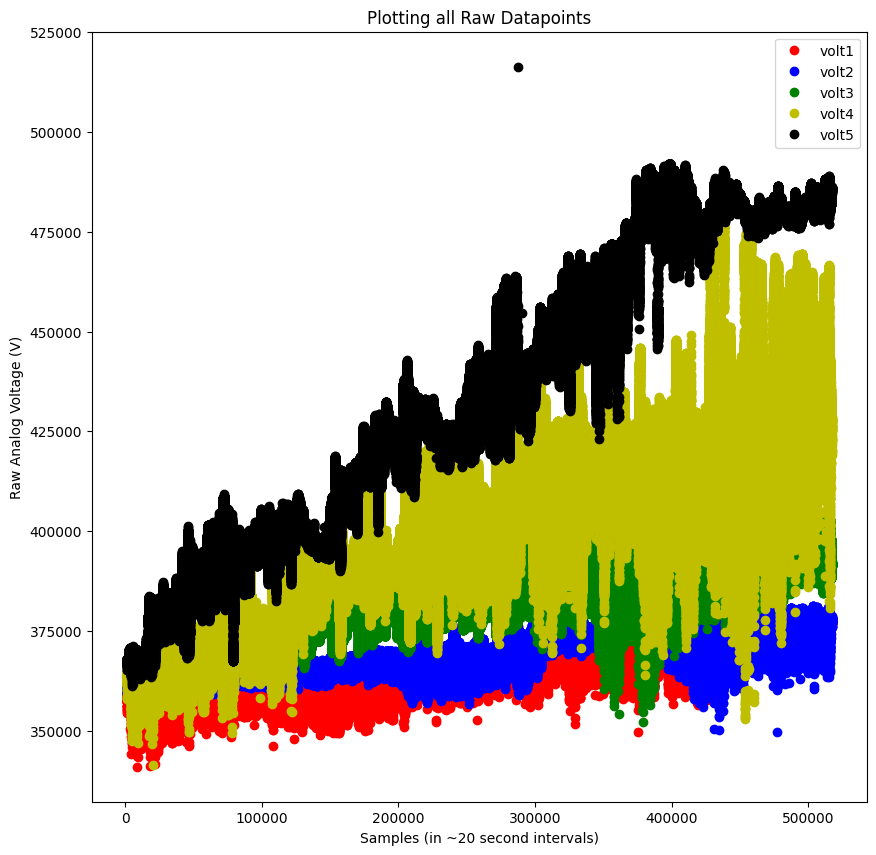

In [10]:
plt.figure(figsize=(10, 10))
plt.plot(df["volt1"], 'ro', label="volt1") # plotting t, a separately
plt.plot(df["volt2"], 'bo', label="volt2") # plotting t, b separately
plt.plot(df["volt3"], 'go', label="volt3") # plotting t, c separately
plt.plot(df["volt4"], 'yo', label="volt4") # plotting t, c separately
plt.plot(df["volt5"], 'ko', label="volt5") # plotting t, c separately
plt.ylabel("Raw Analog Voltage (V)")
plt.xlabel("Samples (in ~20 second intervals)")
plt.title("Plotting all Raw Datapoints")
plt.legend()
plt.show()

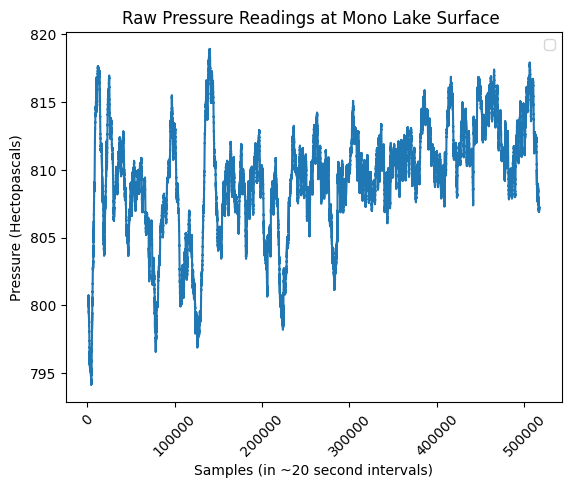

In [11]:
# plt.figure(figsize=(5, 3))
plt.plot(df["pressure"])
plt.ylabel("Pressure (Hectopascals)")
plt.xlabel("Samples (in ~20 second intervals)")
plt.xticks(rotation=45)
plt.title("Raw Pressure Readings at Mono Lake Surface ")
plt.legend()
plt.show()

## Interpolation

### Getting values for interpolation and also making equally spaced timestamps for interpolation

In [12]:
# Getting the timestamps to be used for interpolation

og_pressures = df["pressure"].values.tolist()
og_volt1 = df["volt1"].values.tolist()
og_volt2 = df["volt2"].values.tolist()
og_volt3 = df["volt3"].values.tolist()
og_volt4 = df["volt4"].values.tolist()
og_volt5 = df["volt5"].values.tolist()
og_yorient = df["yorientation"].values.tolist()
og_timestamps = df["server_timestamp"].values.tolist()

print(type(og_timestamps))

first_timestamp = int(og_timestamps[0])
second_timestamp = int(og_timestamps[len(og_timestamps) - 1])
print("first_timestamp: ", first_timestamp)
print("second_timestamp: ", second_timestamp)
des_sample_count = int((second_timestamp - first_timestamp) / 20000)
print("desired num of samples: ", des_sample_count)

<class 'list'>
first_timestamp:  1616639814854
second_timestamp:  1629211785875
desired num of samples:  628598


<class 'int'>
<class 'int'>
<class 'int'>


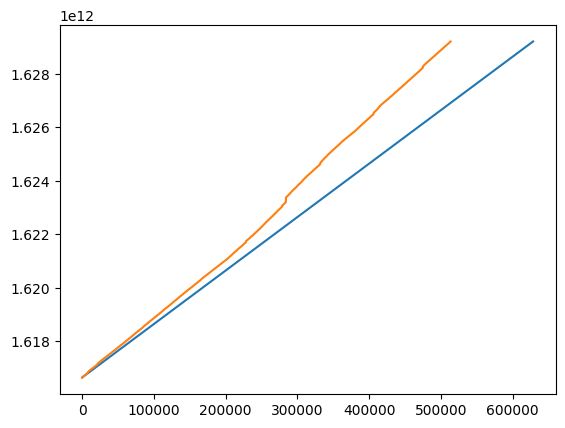

In [13]:
print(type(first_timestamp))
print(type(second_timestamp))
print(type(des_sample_count))
new_timestamps = np.linspace(first_timestamp + 20000, second_timestamp, num=des_sample_count, dtype=int)
plt.plot(new_timestamps)
plt.plot(og_timestamps)

### Removing Ratty Data

In [14]:
for i in range(1, len(og_timestamps)):
  if(og_timestamps[i] == og_timestamps[i - 1]):
    print(i)
    print(i-1)
    print()

print("length: ", len(og_timestamps))
print("last: ", og_timestamps[372513])
print("second to last: ", og_timestamps[372512])
print("in order")

og_timestamps.pop(372513)
og_volt1.pop(372513)
og_volt2.pop(372513)
og_volt3.pop(372513)
og_volt4.pop(372513)
og_volt5.pop(372513)
og_yorient.pop(372513)
og_pressures.pop(372513)

og_timestamps.pop(376997)
og_volt1.pop(376997)
og_volt2.pop(376997)
og_volt3.pop(376997)
og_volt4.pop(376997)
og_volt5.pop(376997)
og_yorient.pop(376997)
og_pressures.pop(376997)

og_timestamps.pop(391686)
og_volt1.pop(391686)
og_volt2.pop(391686)
og_volt3.pop(391686)
og_volt4.pop(391686)
og_volt5.pop(391686)
og_yorient.pop(391686)
og_pressures.pop(391686)

og_timestamps.pop(402176)
og_volt1.pop(402176)
og_volt2.pop(402176)
og_volt3.pop(402176)
og_volt4.pop(402176)
og_volt5.pop(402176)
og_yorient.pop(402176)
og_pressures.pop(402176)

372513
372512

376998
376997

391688
391687

402179
402178

length:  513604
last:  1625689716112
second to last:  1625689716112
in order


808.11

In [15]:
print("length: ", len(og_timestamps))

length:  513600


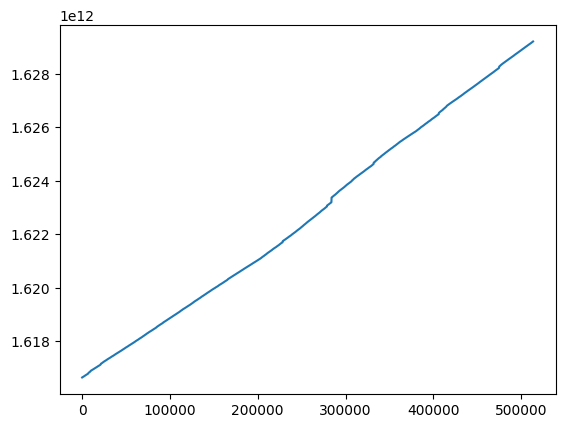

In [16]:
plt.plot(og_timestamps)

### Actually doing interpolation

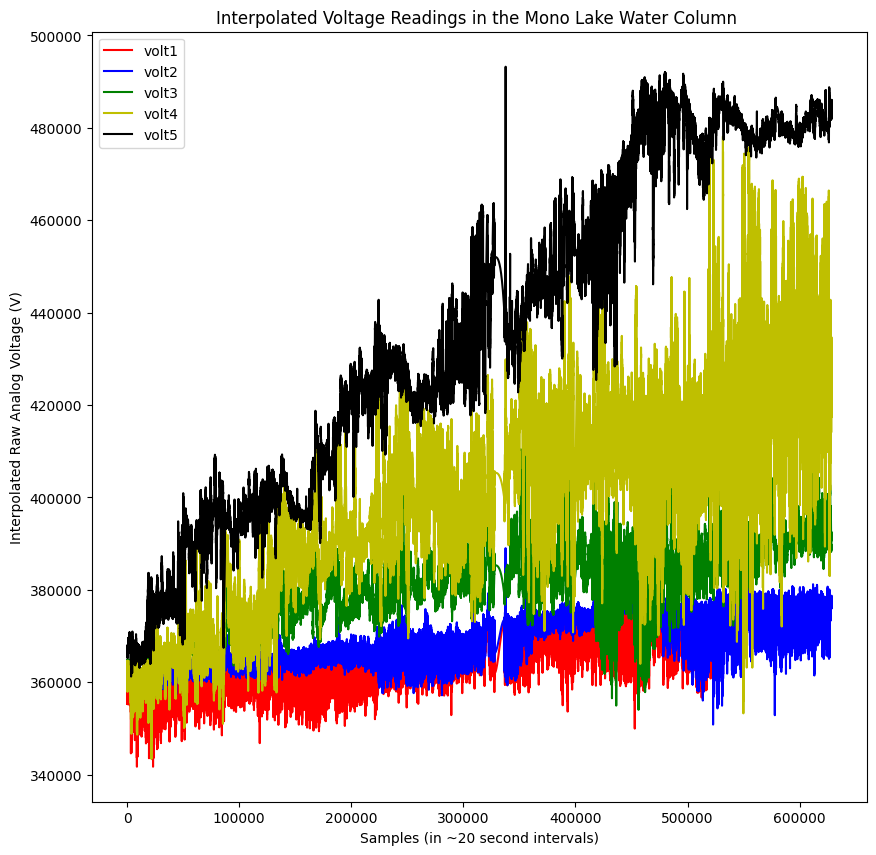

In [17]:
new_timestamps = np.linspace(first_timestamp, second_timestamp, num=des_sample_count)
interp_pressures = pchip_interpolate(og_timestamps, og_pressures, new_timestamps)
interp_volt1 = pchip_interpolate(og_timestamps, og_volt1, new_timestamps)
interp_volt2 = pchip_interpolate(og_timestamps, og_volt2, new_timestamps)
interp_volt3 = pchip_interpolate(og_timestamps, og_volt3, new_timestamps)
interp_volt4 = pchip_interpolate(og_timestamps, og_volt4, new_timestamps)
interp_volt5 = pchip_interpolate(og_timestamps, og_volt5, new_timestamps)
interp_yorient = pchip_interpolate(og_timestamps, og_yorient, new_timestamps)

plt.figure(figsize=(10, 10))
plt.plot(interp_volt1, 'r', label="volt1") # plotting t, a separately
plt.plot(interp_volt2, 'b', label="volt2") # plotting t, b separately
plt.plot(interp_volt3, 'g', label="volt3") # plotting t, c separately
plt.plot(interp_volt4, 'y', label="volt4") # plotting t, c separately
plt.plot(interp_volt5, 'k', label="volt5") # plotting t, c separately
plt.ylabel("Interpolated Raw Analog Voltage (V)")
plt.xlabel("Samples (in ~20 second intervals)")
plt.title("Interpolated Voltage Readings in the Mono Lake Water Column ")
plt.legend()
plt.show()

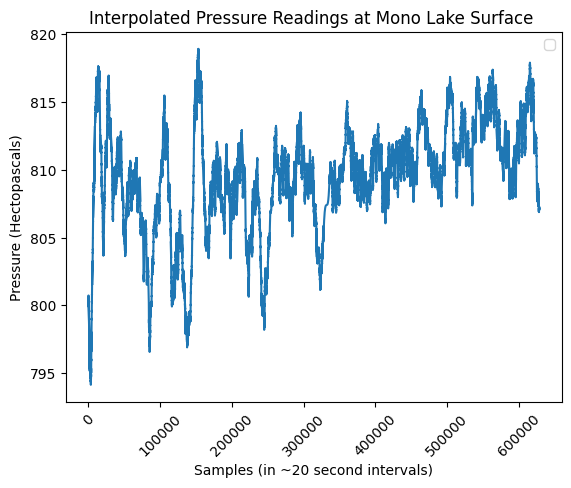

In [18]:
# plt.figure(figsize=(5, 3))
plt.plot(interp_pressures)
plt.ylabel("Pressure (Hectopascals)")
plt.xlabel("Samples (in ~20 second intervals)")
plt.xticks(rotation=45)
plt.title("Interpolated Pressure Readings at Mono Lake Surface ")
plt.legend()
plt.show()

## Filtering
Our raw data sample rate is roughly every 20 seconds and after interpolation it's exactly 20 seconds which correpsonds to a sampling frequency of 0.05 Hz. This means the Nyquist frequency is 0.025 Hz. We want to filter out trends longer than 11-ish hours, so we'll filter out frequencies slower than 0.000025Hz which corresponds to a normalized cutoff of 0.001

In [19]:
# Filtering Volts
sos_volt1 = signal.butter(1,.001, 'hp', output='sos')
filtered_volt1 = signal.sosfilt(sos_volt1, interp_volt1)
sos_volt2 = signal.butter(1,.001, 'hp', output='sos')
filtered_volt2 = signal.sosfilt(sos_volt2, interp_volt2)
sos_volt3 = signal.butter(1,.001, 'hp', output='sos')
filtered_volt3 = signal.sosfilt(sos_volt3, interp_volt3)
sos_volt4 = signal.butter(1,.001, 'hp', output='sos')
filtered_volt4 = signal.sosfilt(sos_volt4, interp_volt4)
sos_volt5 = signal.butter(1,.001, 'hp', output='sos')
filtered_volt5 = signal.sosfilt(sos_volt5, interp_volt5)

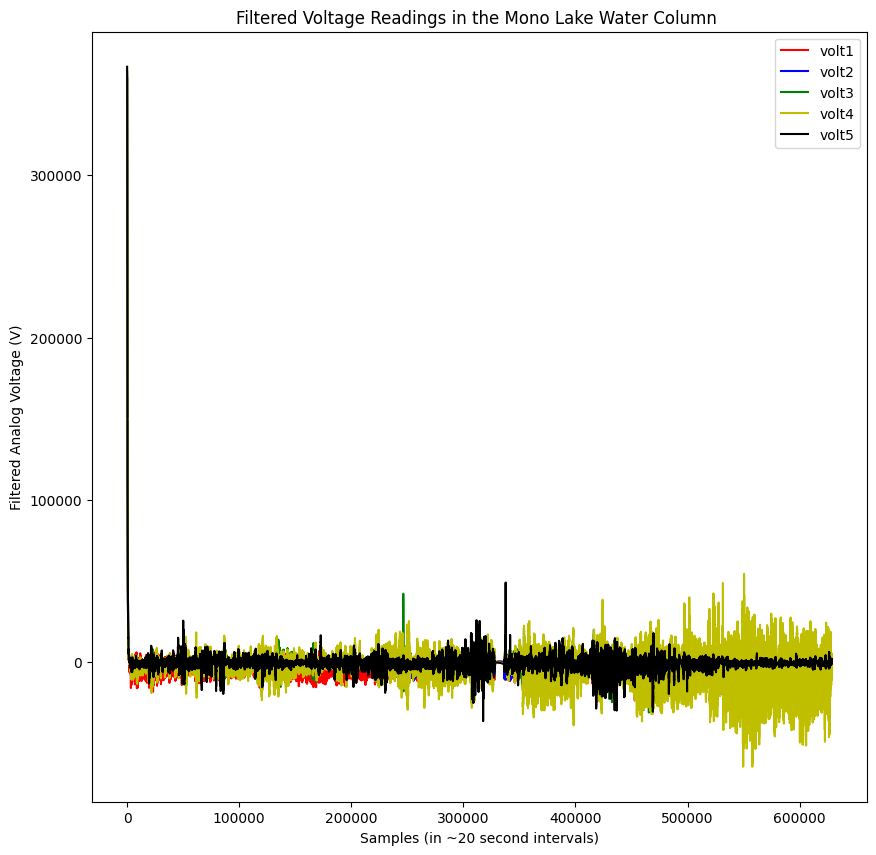

In [20]:
plt.figure(figsize=(10, 10))
plt.plot(filtered_volt1, 'r', label="volt1") # plotting t, a separately
plt.plot(filtered_volt2, 'b', label="volt2") # plotting t, b separately
plt.plot(filtered_volt3, 'g', label="volt3") # plotting t, c separately
plt.plot(filtered_volt4, 'y', label="volt4") # plotting t, c separately
plt.plot(filtered_volt5, 'k', label="volt5") # plotting t, c separately
plt.ylabel("Filtered Analog Voltage (V)")
plt.xlabel("Samples (in ~20 second intervals)")
plt.title("Filtered Voltage Readings in the Mono Lake Water Column ")
plt.legend()
plt.show()

In [21]:

interp_pressures = interp_pressures[1700:]
# filtered_pressure = filtered_pressure[1700:]
filtered_volt1 = filtered_volt1[1700:]
filtered_volt2 = filtered_volt2[1700:]
filtered_volt3 = filtered_volt3[1700:]
filtered_volt4 = filtered_volt4[1700:]
filtered_volt5 = filtered_volt5[1700:]
# interp_yorient = interp_yorient[1700:]
new_timestamps = new_timestamps[1700:]

volts = [filtered_volt1, filtered_volt2, filtered_volt3, filtered_volt4, filtered_volt5]

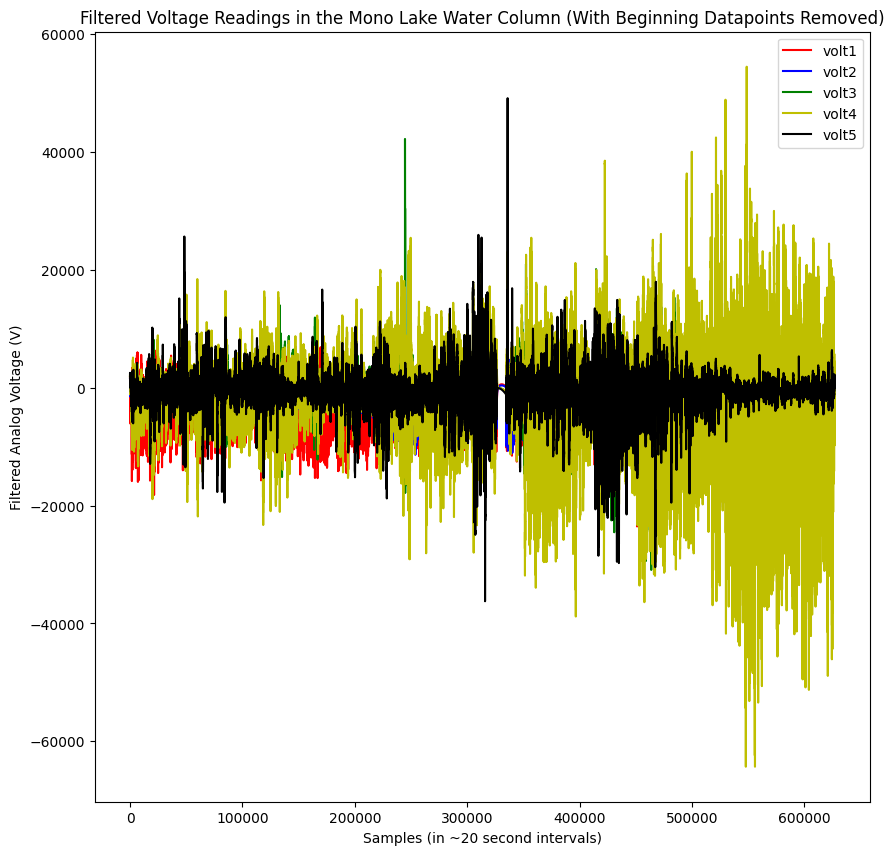

In [22]:
plt.figure(figsize=(10, 10))
plt.plot(filtered_volt1, 'r', label="volt1") # plotting t, a separately
plt.plot(filtered_volt2, 'b', label="volt2") # plotting t, b separately
plt.plot(filtered_volt3, 'g', label="volt3") # plotting t, c separately
plt.plot(filtered_volt4, 'y', label="volt4") # plotting t, c separately
plt.plot(filtered_volt5, 'k', label="volt5") # plotting t, c separately
plt.ylabel("Filtered Analog Voltage (V)")
plt.xlabel("Samples (in ~20 second intervals)")
plt.title("Filtered Voltage Readings in the Mono Lake Water Column (With Beginning Datapoints Removed)")
plt.legend()
plt.show()

In [23]:
pressures = interp_pressures

# Granger Functions

In [24]:
from sklearn.metrics.pairwise import pairwise_distances

In [26]:
# Helper Functions
def is_stationary(begin, end):
  print("STARTING STATIONARITY TESTING WINDOW: ", begin, " TO ", end)
  stationary_results = []
  for i in range(0, len(volts)):
    stationary_results.append(adfuller(volts[i][begin:end:20])[1])
    if stationary_results[i] > 0.05:
      print("FILTERED VOLT ", i, " NOT STATIONARY FOR ", begin, " to ", end, " WITH VALUE: ", stationary_results[i])

  pressure_stationarity = adfuller(pressures[begin:end:20])[1]
  if (pressure_stationarity > 0.05):
    print("INTERP PRESSURE NOT STATIONARY FOR ", begin, " to ", end, " WITH VALUE: ", pressure_stationarity)

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [28]:
def generate_granger_figure_pressure_only(begin, end, volts, causes):
    print("STARTING GRANGER RUN FOR WINDOW: ", begin, " TO ", end)
    import warnings
    warnings.filterwarnings('ignore')
    granger_results = []
    for ets in volts:
        gres = []
        ets = ets[begin:end:20]
        for cts in causes:
            cts = cts[begin:end:20]
            g_input = np.concatenate([np.vstack(ets), np.vstack(cts)], axis=1)
            results = grangercausalitytests(g_input, maxlag=80, verbose=0)
            p_vals = []
            for lag in results:
                p_vals.append(results[lag][0]['ssr_ftest'][1])
            result = min(p_vals)
            gres.append(result)
        granger_results.append(gres)

    granger_results = np.array(granger_results)
    print(granger_results)
    granger_results_inv = 1-1/(1+np.exp(-100*granger_results-0.01))
    # temp_xdata = pairwise_distances(granger_results_inv, metric='cosine')

    print(granger_results_inv)
    linkage_mat = linkage(granger_results_inv, method='complete')
    plt.figure()
    dendrogram(linkage_mat, labels = ["35 Meters", "25 Meters", "15 Meters", "10 Meters", "5 Meters"])
    plt.show()

### Monthly Plots

In [31]:
# Find Indices for Month Start times
# times = [1617253200000, 1618444800000, 1619845200000]
# months = ["Apr1", "Apr15", "May1"]
times = [1619845200000, 1622523600000, 1625115600000, 1627794000000]
months = ["May", "Jun", "Jul", "Aug"]
counter = 0
time_indices = []
for i in range(0, len(new_timestamps)):
  if new_timestamps[i] > times[counter]:
    print(months[counter] + ": ", i)
    time_indices.append(i)
    counter += 1
    if(counter == len(times)):
      break

May:  158569
Jun:  292489
Jul:  422089
Aug:  556008


### Granger pressure - temperature dendrograms

STARTING  May
STARTING STATIONARITY TESTING WINDOW:  158569  TO  292489
STARTING GRANGER RUN FOR WINDOW:  158569  TO  292489
[[2.21951455e-01]
 [7.83014680e-02]
 [1.44755760e-04]
 [3.07668328e-04]
 [1.51155682e-03]]
[[2.27210251e-10]
 [3.93456384e-04]
 [4.93881411e-01]
 [4.89809703e-01]
 [4.59798050e-01]]


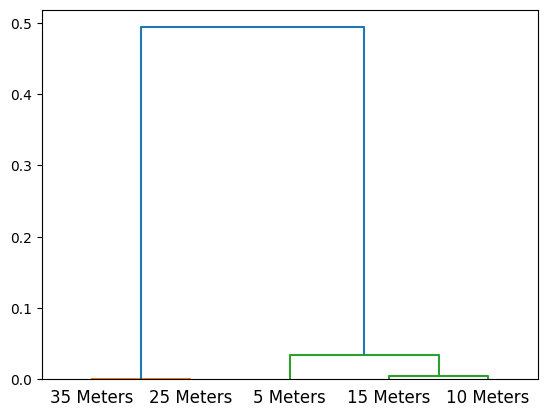

STARTING  Jun
STARTING STATIONARITY TESTING WINDOW:  292489  TO  422089
STARTING GRANGER RUN FOR WINDOW:  292489  TO  422089
[[1.00274355e-01]
 [7.28569620e-01]
 [9.44924668e-11]
 [9.48743801e-03]
 [3.31513878e-14]]
[[4.37298673e-05]
 [0.00000000e+00]
 [4.97500018e-01]
 [2.77129777e-01]
 [4.97500021e-01]]


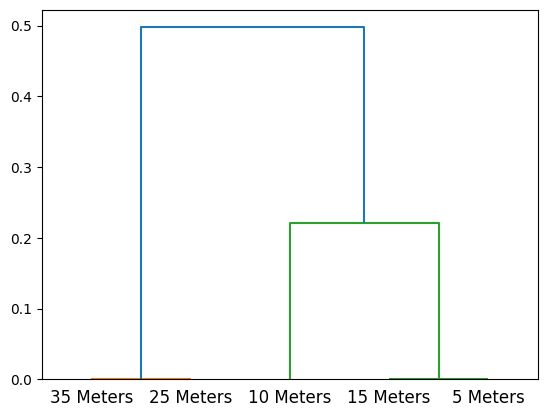

STARTING  Jul
STARTING STATIONARITY TESTING WINDOW:  422089  TO  556008
STARTING GRANGER RUN FOR WINDOW:  422089  TO  556008
[[0.04912104]
 [0.05527881]
 [0.02203835]
 [0.1697178 ]
 [0.10952265]]
[[7.23111839e-03]
 [3.91943499e-03]
 [9.85149919e-02]
 [4.21605850e-08]
 [1.73436827e-05]]


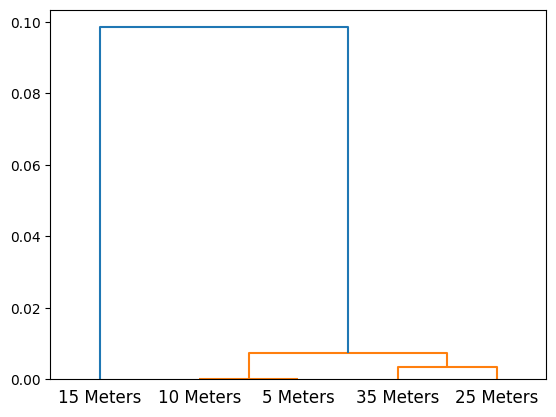

In [32]:
# All Months are stationary for BOTH raw pressures and filtered pressures

causes = [pressures]
for i in range(0, len(time_indices) - 1):
  print("STARTING ", months[i])
  is_stationary(time_indices[i], time_indices[i + 1])
  generate_granger_figure_pressure_only(time_indices[i], time_indices[i + 1], volts, causes)

# is_stationary(0, time_indices[0])
# generate_granger_figure(0, time_indices[0], volts, causes, "Months")

# Trying DTW Between the temperatures only

In [33]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.2 MB/s eta 0:00:00


In [34]:
import math
from dtaidistance import dtw
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score

In [38]:
def get_euclidean_distance_matrix(causal_timeseries, effect_timeseries, begin, end):
    euc_results = []
    for c in causal_timeseries:
        one_row_result = []
        c = c[begin:end:20]
        for e in effect_timeseries:
            e = e[begin:end:20]
            temp_dist = math.dist(c, e)
            one_row_result.append(temp_dist)
        euc_results.append(one_row_result)

    return np.array(euc_results)

def get_dtw_distance_matrix(causal_timeseries, effect_timeseries, begin, end):
    dtw_dist_matrix =[]
    for input in causal_timeseries:
        row = []
        input = input[begin:end:20]
        for effect in effect_timeseries:
            effect = effect[begin:end:20]
            distance = dtw.distance_fast(input, effect)
            row.append(distance)
        dtw_dist_matrix.append(row)
    return np.array(dtw_dist_matrix)

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()
volts_standardized = scaler.fit_transform(volts)
pressures_standardized = scaler.fit_transform([pressures])

STARTING GRANGER RUN FOR May:  158569  TO  292489
STARTING GRANGER RUN FOR June:  292489  TO  422089
STARTING GRANGER RUN FOR July:  422089  TO  556008


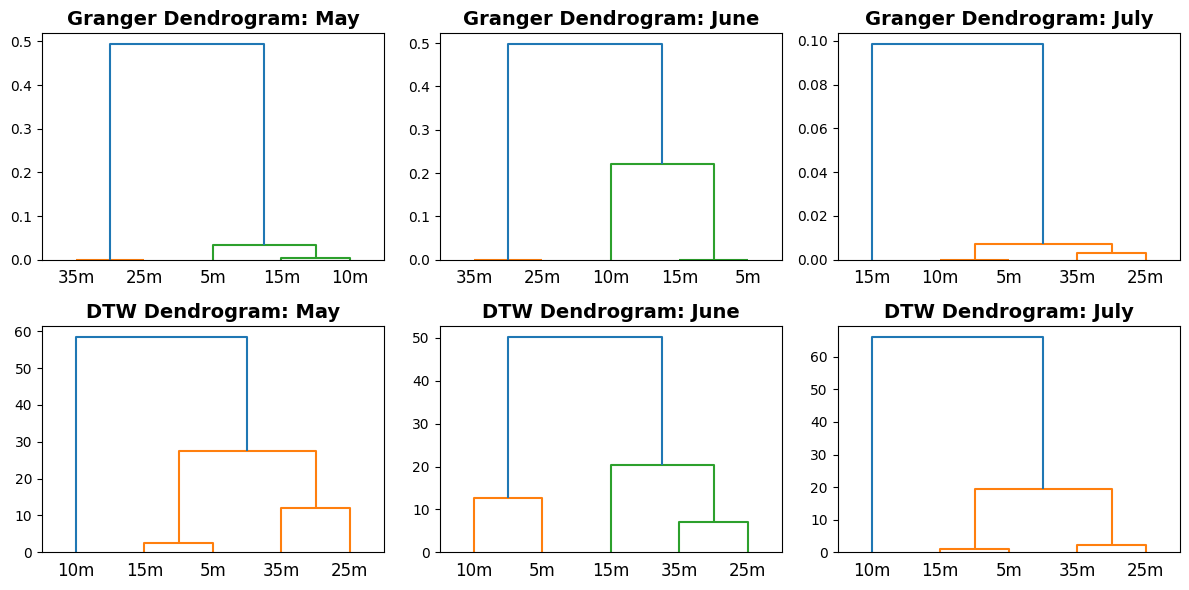

In [43]:
# Shrinking down:

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

def generate_granger_dendrogram(ax, begin, end, volts, causes, month_label):
    print(f"STARTING GRANGER RUN FOR {month_label}: ", begin, " TO ", end)
    granger_results = []
    for ets in volts:
        gres = []
        ets = ets[begin:end:20]
        for cts in causes:
            cts = cts[begin:end:20]
            g_input = np.concatenate([np.vstack(ets), np.vstack(cts)], axis=1)
            results = grangercausalitytests(g_input, maxlag=80, verbose=0)
            p_vals = [results[lag][0]['ssr_ftest'][1] for lag in results]
            gres.append(min(p_vals))
        granger_results.append(gres)

    granger_results = np.array(granger_results)
    granger_results_inv = 1 - 1 / (1 + np.exp(-100 * granger_results - 0.01))
    linkage_mat = linkage(granger_results_inv, method='complete')
    dendrogram(linkage_mat, labels=["35m", "25m", "15m", "10m", "5m"], ax=ax)
    ax.set_title(f'Granger Dendrogram: {month_label}', fontsize=14, fontweight='bold')

def generate_dtw_dendrogram(ax, begin, end, volts_standardized, pressures_standardized, month_label):
    dist_mat = get_dtw_distance_matrix(pressures_standardized, volts_standardized, begin, end)
    linkage_mat = linkage(dist_mat.reshape(-1, 1), method='complete')
    dendrogram(linkage_mat, labels=["35m", "25m", "15m", "10m", "5m"], ax=ax)
    ax.set_title(f'DTW Dendrogram: {month_label}', fontsize=14, fontweight='bold')

# Create a 2x3 figure
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# Define the months and their indices
months = ['May', 'June', 'July']
time_ranges = [(0, 100), (100, 200), (200, 300)]  # Example ranges for each month

# Generate Granger dendrograms for the top row
for i in range(0, len(months)):
    generate_granger_dendrogram(axs[0, i], time_indices[i], time_indices[i + 1], volts, causes, months[i])

# Generate DTW dendrograms for the bottom row
for i in range(0, len(months)):
    generate_dtw_dendrogram(axs[1, i], time_indices[i], time_indices[i + 1], volts_standardized, pressures_standardized, months[i])

# Adjust layout
plt.tight_layout()
# plt.savefig(base_dir + "figures/dtw_and_granger_dendrograms.png")
plt.show()


# The LADWP Data

In [44]:
LADWP = pd.read_excel(base_dir + "LADWP_Data_2021.xlsx")
LADWP.head()

,Date,Station,Depth,Temp_C
0,2021-05-18 08:52:00,3,0.5,15.1208
1,2021-05-18 08:52:00,3,1.0,14.4664
2,2021-05-18 08:52:00,3,1.5,14.2854
3,2021-05-18 08:52:00,3,2.0,14.2743
4,2021-05-18 08:52:00,3,2.5,14.0379


In [45]:
# filter LADWP for only station 12 which was very close to the location from which
# the data used in the clustering was collected

LADWP_station_12 = LADWP[LADWP['Station'] == 12]
LADWP_station_12['Date'] = pd.to_datetime(LADWP_station_12['Date'])
LADWP_station_12['Month'] = pd.to_datetime(LADWP_station_12['Date']).dt.month
LADWP_station_12.head()

,Date,Station,Depth,Temp_C,Month
442,2021-05-18 12:14:00,12,0.5,17.0391,5
443,2021-05-18 12:14:00,12,1.0,16.5485,5
444,2021-05-18 12:14:00,12,1.5,15.6183,5
445,2021-05-18 12:14:00,12,2.0,14.9709,5
446,2021-05-18 12:14:00,12,2.5,14.6564,5


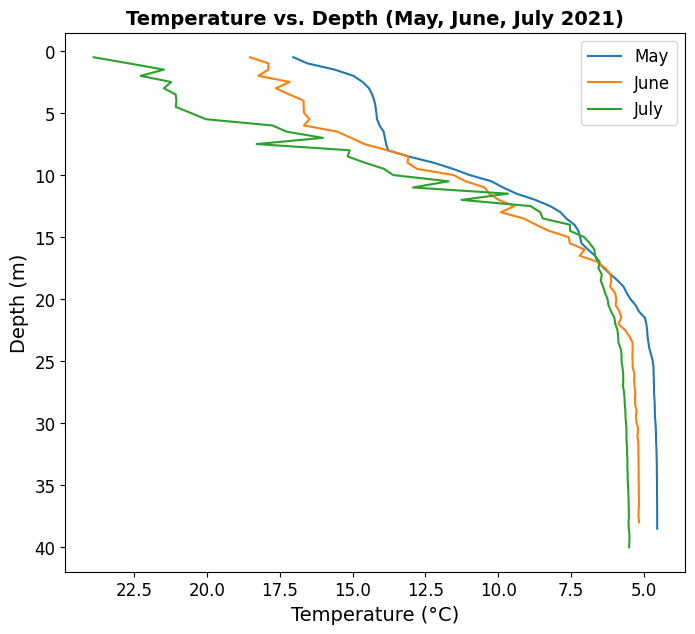

In [46]:
# Create the plot
plt.figure(figsize=(8, 7))

# Plot for each month (5, 6, and 7)
month_names = ['May', 'June', 'July']
for i, month in enumerate([5, 6, 7]):
    df_month = LADWP_station_12[LADWP_station_12['Month'] == month]
    plt.plot(df_month['Temp_C'], df_month['Depth'], label=f'{month_names[i]}')

# Invert y-axis to have depth in descending order
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Adding labels and title
plt.xlabel('Temperature (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Depth (m)',  fontsize=14)
plt.title('Temperature vs. Depth (May, June, July 2021)',  fontsize=14, fontweight='bold')
plt.legend(fontsize=12)

# plt.savefig(base_dir + "figures/temperature_depth_profile.png")

# Show the plot
plt.show()